<a href="https://colab.research.google.com/github/racheltu2020/DS-Unit-1-Sprint-2-Statistics/blob/master/module3/LS_DS_123_Introduction_to_Bayesian_Inference_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science Module 123

## Introduction to Bayesian Inference




## Assignment - Code it up!

We used pure math to apply Bayes Theorem to drug tests. Now write Python code to reproduce the results! This is purposefully open ended - you'll have to think about how you should represent probabilities and events. You can and should look things up.

Specific goals/targets:

### 1) Write a function 

`def prob_drunk_given_positive(prob_drunk_prior, false_positive_rate, true_positive_rate):` 

You should only truly need these two values in order to apply Bayes Theorem. In this example, imagine that individuals are taking a breathalyzer test with an 8% false positive rate, a 100% true positive rate, and that our prior belief about drunk driving in the population is 1/1000. 
 - What is the probability that a person is drunk after one positive breathalyzer test?
 - What is the probability that a person is drunk after two positive breathalyzer tests?
 - How many positive breathalyzer tests are needed in order to have a probability that's greater than 95% that a person is drunk beyond the legal limit?

### 2) Explore `scipy.stats.bayes_mvs`  
Read its documentation, and experiment with it on data you've tested in other ways earlier this week.
 - Create a visualization comparing the results of a Bayesian approach to a traditional/frequentist approach. (with a large sample size they should look close to identical, however, take this opportunity to practice visualizing condfidence intervals in general. The following are some potential ways that you could visualize confidence intervals on your graph:
  - [Matplotlib Error Bars](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.errorbar.html)
  - [Seaborn barplot with error bars](https://seaborn.pydata.org/generated/seaborn.barplot.html)
  - [Vertical ines to show bounds of confidence interval](https://www.simplypsychology.org/confidence-interval.jpg)
  - [Confidence Intervals on Box Plots](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.axes.Axes.boxplot.html)

### 3) In your own words, summarize the difference between Bayesian and Frequentist statistics

If you're unsure where to start, check out [this blog post of Bayes theorem with Python](https://dataconomy.com/2015/02/introduction-to-bayes-theorem-with-python/).



In [0]:
# TODO - code!
import pandas as pd
import numpy as np
from scipy import stats


def prob_posterior(prior, false_rate, true_rate):
  
  num  = true_rate * prior
  den  = true_rate * prior + ( 1-prior) * false_rate
  posterior = num/den
  return  posterior

In [0]:

probabilities = [] # assign empty array to store prier and posterior posibilities
                    
prior = 0.001       # drunk driving rate 
false_rate = 0.08   # test gave out false positive rate
true_rate = 1       # true positive rate

probabilities.append(prior)

num  = true_rate * prior
den  = true_rate * prior + ( 1-prior) * false_rate
posterior = num/den

for i in range(1, 11):
  prior = prob_posterior(prior, false_rate, true_rate)
  probabilities.append(prior)

probabilities



[0.001,
 0.012357884330202669,
 0.13525210993291495,
 0.6615996951348605,
 0.9606895076105054,
 0.9967371577896734,
 0.9997381867081508,
 0.9999790498904363,
 0.9999983239589307,
 0.9999998659165077,
 0.9999999892733192]

In [0]:
# breathalyzer test :
# the originally drunk driving rate is 0.012357884330202669,

# after the 1st breathalyzer test, the probability only has 1.2357884330202669% to suggest true drunk 

# after the 2nd breathalyzer test, the probability only has 13.525210993291495% to suggest true drunk

# after the 3rd breathalyzer test, the probability only has 66.15996951348605%  to suggest true drunk

# after the 4th breathalyzer test, the probability only has 96.06895076105054% to suggest true drunk

# after 4 times of drunk driving test, the statistic data suggest the probability 
# is greater than 95% that a person is drunk beyond the legal limit.


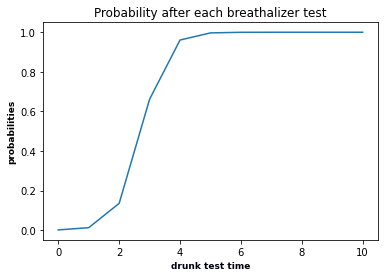

In [0]:
import matplotlib.pyplot as plt

plt.plot(probabilities)
plt.title("Probability after each breathalizer test")
plt.xlabel('drunk test time', fontsize=9, fontweight='bold', color='#000010')
plt.ylabel('probabilities', fontsize=9, fontweight='bold')
plt.show()

In [0]:
# import
import pandas as pd
import numpy as np
from scipy import stats

df = pd.read_csv("https://raw.githubusercontent.com/ryanleeallred/datasets/master/adult.csv", na_values=' ?')

print(df.shape)
df.head()       # size (32561, 15)

(32561, 15)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [0]:
# choose census responders 'age' to compare and plot

df['age'].mean()  # their mean value is 38.58164675532078

sample['age'] = df['age'].sample(500)  # sample size is 500 from df['age'] (act as our sample size population)
sample['age'].mean()

38.122

In [0]:

def confidence_interval(data, confidence=0.95):
  """
  Calculate a confidence interval around a sample mean for given data.
  Using t-distribution and two-tailed test, default 95% confidence. 
  
  Arguments:
    data - iterable (list or numpy array) of sample observations
    confidence - level of confidence for the interval
  
  Returns:
    tuple of (mean, lower bound, upper bound)
  """
  data = np.array(data)
  mean = np.mean(data)
  n = len(data)
  # pass extra parameter (ddof=1) to calculate **sample** standard deviation
  s = data.std(ddof=1)
  stderr = s / np.sqrt(n)
  
  # Lookup the t-statistic that corresponds to 95% area under the curve
  # for my given degrees of freedom: 49
  t = stats.t.ppf((1 + confidence) / 2.0, n - 1)
  margin_of_error = t*stderr
  return (mean - margin_of_error, mean, mean + margin_of_error)

In [0]:
frequentist = confidence_interval(sample['age'])
frequentist

(36.944281374829025, 38.122, 39.299718625170975)

In [0]:
# bayes theorem :

bayesian, _, _ = stats.bayes_mvs(sample['age'], alpha=.95)
bayesian

Mean(statistic=38.122, minmax=(36.944281374829025, 39.299718625170975))

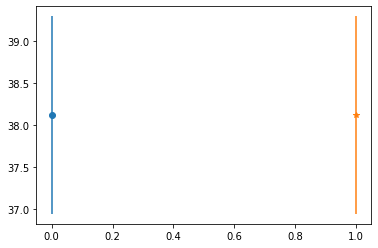

In [0]:
plt.errorbar(x=0, y=frequentist[1], yerr=(frequentist[2]-frequentist[1]), fmt='o')
plt.errorbar(x=1, y=bayesian.statistic, yerr=(bayesian.minmax[1]-bayesian.statistic), fmt='*')
plt.show()

# blue  is frequentist
# orange is bayesian plot

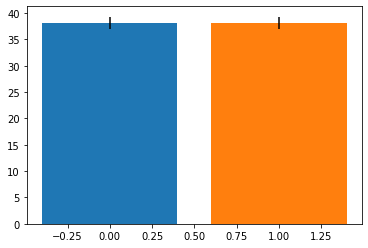

In [0]:
plt.bar(x=0, height=frequentist[1], yerr=(frequentist[2]-frequentist[1]))
plt.bar(x=1, height=bayesian.statistic, yerr=(bayesian.minmax[1]-bayesian.statistic))
plt.show()

In [0]:
# The philosophy behind them is basic different, 
# Frequentist is to analyze data, at model setting is fixed.

# but Bayesian way is not focus on the fixed model setting, on certainty and non-certainty, and towards non-certainty way to tackle it.


## Resources

- [Worked example of Bayes rule calculation](https://en.wikipedia.org/wiki/Bayes'_theorem#Examples) (helpful as it fully breaks out the denominator)
- [Source code for mvsdist in scipy](https://github.com/scipy/scipy/blob/90534919e139d2a81c24bf08341734ff41a3db12/scipy/stats/morestats.py#L139)

## Stretch Goals:

- Go back and study the content from Modules 1 & 2 to make sure that you're really comfortable with them.
- Apply a Bayesian technique to a problem you previously worked (in an assignment or project work) on from a frequentist (standard) perspective
- Check out [PyMC3](https://docs.pymc.io/) (note this goes beyond hypothesis tests into modeling) - read the guides and work through some examples
- Take PyMC3 further - see if you can build something with it!